# Introduction: Automated Feature Engineering Basics

In this notebook, we will walk through the process of applying automated feature engineering to the [Home Credit Default Risk dataset](https://www.kaggle.com/c/home-credit-default-risk) using the featuretools library. [Featuretools](https://docs.featuretools.com/) is an open-source Python package for automatically creating new features from multiple tables of structured, related data. It is ideal tool for problems such as the Home Credit Default Risk competition where there are several related tables that need to be combined into a single dataframe for training (and one for testing). 

## Feature Engineering

The objective of feature engineering is to represent as much information from the separate tables as possible in a single table. Some of the tables will be child tables and some will be parents (we will discuss this in a little bit) so combining the data requires grouping by the parent, aggregating statistics across the children, and merging the data back together. Typically, this process is done by hand using pandas operations such as `groupby`, `agg`, or `merge` and can be very tedious. Moreover, manual feature engineering is limited both by human time constraints and imagination: we simply cannot conceive of every possible feature that will be useful. (For an example of using manual feature engineering, check out [part one](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering) and [part two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2) applied to this competition). The importance of creating the proper features cannot be overstated because a machine learning model can only learn from the data we give to it. Extracting as much information as possible from the available datasets is crucial to creating an effective solution.

Automated feature engineering aims to help the data scientist with this problem by automatically creating hundreds or thousands of new features from a dataset. Featuretools - the only library for automated feature engineering at the momemt - will not replace the data scientist, because there is still room for guiding the algorithm and selecting features, but it will allow her to focus on more valuable parts of the machine learning pipeline, such as delivering robust models into production. 

Here we will walk through the concepts of automated feature engineering and show how to implement it for the Home Credit Default Risk competition. We will work with a subset of the data because this is a computationally intensive job that is outside the capabilities of the Kaggle kernels. I took the work done in this notebook and ran the methods on the entire dataset with the results [available here](https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools). At the end of this notebook, we'll look at the features themselves, as well as the results of modeling with different combinations of hand designed and automatically built features. 

If you are new to this competition, I suggest checking out [this post to get started](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction). For a good take on why features are so important, here's a [good blog post](https://www.featurelabs.com/blog/secret-to-data-science-success/) by one of the developers of Featuretools. 

In [ ]:
# Uncomment and run if kernel does not already have featuretools
# !pip install featuretools

In [2]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Problem

The Home Credit Default Risk competition is a supervised classification machine learning task. The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

## Dataset

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. 

There are 7 different data files:

* __application_train/application_test__: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the `SK_ID_CURR`. The training application data comes with the `TARGET` with indicating 0: the loan was repaid and 1: the loan was not repaid. 
* __bureau__: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau and is identified by the `SK_ID_BUREAU`, Each loan in the application data can have multiple previous credits.
* __bureau_balance__: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* __previous_application__: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* __POS_CASH_BALANCE__: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* __credit_card_balance__: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment__: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

The diagram below (provided by Home Credit) shows how the tables are related. This will be very useful when we need to define relationships in featuretools. 

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

### Read in Data and Create Small Datasets

We will read in the full dataset, sort by the `SK_ID_CURR` and keep only the first 1000 rows to make the calculations feasible. Later we can convert to a script and run with the entire datasets.

In [3]:
app_train = pd.read_csv('../input/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
app_test = pd.read_csv('../input/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
bureau = pd.read_csv('../input/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('../input/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('../input/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('../input/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('../input/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('../input/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

In [4]:
# # Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# # This allows us to actually see the results in a reasonable amount of time! 
# app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
# app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
# bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
# bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
# cash = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
# credit = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
# previous = pd.read_csv('../input/home-credit-default-risk/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
# installments = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

We'll join the train and test set together but add a separate column identifying the set. This is important because we are going to want to apply the same exact procedures to each dataset. It's safest to just join them together and treat them as a single dataframe. 

In [5]:
# Join the appliation dataframes together
app_test['set'] = 'test'
app_test['TARGET'] = -999
app_train['set'] = 'train'

# Append the dataframes (this is a row bind in R)
app = app_train.append(app_test, ignore_index = True)

# Featuretools Basics

[Featuretools](https://docs.featuretools.com/#minute-quick-start) is an open-source Python library for automatically creating features out of a set of related tables. Automated feature engineering, like many topics in machine learning, is a complex subject built upon a foundation of simpler ideas. By going through these ideas one at a time, we can build up our understanding of how featuretools which will later allow us to customize featuretools to get the most out of it. There are a few concepts that we will cover along the way:

* [Entities and EntitySets](https://docs.featuretools.com/loading_data/using_entitysets.html)
* [Relationships between tables](https://docs.featuretools.com/loading_data/using_entitysets.html#adding-a-relationship)
* [Feature primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html): aggregations and transformations
* [Deep feature synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html)

# Entities and Entitysets

An entity is simply a table or in Pandas, a `dataframe`. The observations are in the rows and the features in the columns. An entity in featuretools must have a unique index where none of the elements are duplicated.  Currently, only `app`, `bureau`, and `previous` have unique indices (`SK_ID_CURR`, `SK_ID_BUREAU`, and `SK_ID_PREV` respectively). For the other dataframes, we must pass in `make_index = True` and then specify the name of the index. Entities can also have time indices where each entry is identified by a unique time. (There are not datetimes in any of the data, but there are relative times, given in months or days, that we could consider treating as time variables).

An [EntitySet](https://docs.featuretools.com/loading_data/using_entitysets.html) is a collection of tables and the relationships between them. This can be thought of as another data structute with its own methods and attributes. Using an EntitySet allows us to group together multiple tables and manipulate them much quicker than individual tables. 

First we'll make an empty entityset named clients to keep track of all the data.

In [6]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

Now we define each entity, or table of data. At this point we can also specify feature types. Featuretools will automatically infer types, but if we have a categorical variable that is represented as an integer we might want to let featuretools know that is categorical otherwise it will be assumed numeric. 

In [7]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

## Relationships

Relationships are a fundamental concept not only in featuretools, but in any relational database. The best way to think of a one-to-many relationship is with the analogy of parent-to-child. A parent is a single individual, but can have mutliple children. The children can then have multiple children of their own. In a _parent table_, each individual has a single row. Each individual in the parent table can have multiple rows in the _child table_. 

As an example, the `app` dataframe has one row for each client  (`SK_ID_CURR`) while the `bureau` dataframe has multiple previous loans (`SK_ID_PREV`) for each parent (`SK_ID_CURR`). Therefore, the `bureau` dataframe is the child of the `app` dataframe. The `bureau` dataframe in turn is the parent of `bureau_balance` because each loan has one row in `bureau` but multiple monthly records in `bureau_balance`. 

In [8]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n',app.iloc[:, 111:115].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

    SK_ID_CURR  TARGET  TOTALAREA_MODE WALLSMATERIAL_MODE
0      100002       1          0.0149       Stone, brick
1      100003       0          0.0714              Block
2      100004       0             NaN                NaN
3      100006       0             NaN                NaN
4      100007       0             NaN                NaN

Child: bureau, Child Variable: SK_ID_CURR

     SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
10      100002       6158905        Closed      currency 1
11      100002       6158906        Closed      currency 1
12      100002       6158907        Closed      currency 1
13      100002       6158908        Closed      currency 1
14      100002       6158909        Active      currency 1


Two tables are linked via a shared variable. The `app` and `bureau` dataframe are linked by the `SK_ID_CURR` variable while the `bureau` and `bureau_balance` dataframes are linked with the `SK_ID_BUREAU`. Sometimes variables will be the same across tables but will have different names. However, that is not the case here which makes defining the relationships relatively straightforward. The diagram provided by the competition is helpful for viewing all the relationships. For each relationship in the data, we need to identify the parent, the parent variable, the child, and the child variable. 

Slightly advanced note: we need to be careful to not create a [diamond graph](https://en.wikipedia.org/wiki/Diamond_graph) where there are multiple paths from a parent to a child. If we link `app` and `cash` via `SK_ID_CURR`; `previous` and `cash` via `SK_ID_PREV`; and `app` and `previous` via `SK_ID_CURR`, then we have created two paths from `app` to `cash`. This results in ambiguity, so the approach we have to take instead is to link `app` to `cash` via `previous`. We establish a relationship between `previous` (the parent) and `cash` (the child) using `SK_ID_PREV`. Then we establish a relationship between `app` (the parent) and `previous` (now the child) using `SK_ID_CURR`. This allows us to encode the monthly information about previous loans on a per client basis : we first aggregate the montly statements of previous loans, and then we aggregate the aggregations of previous loans for each client. In the terms of feature tools, this would be a [feature with a depth of 2](https://docs.featuretools.com/automated_feature_engineering/afe.html).

Altogether, there are a total of 6 relationships between the tables. Defining the relationship requires specifying the parent variable and then the child variable. Below we specify all six relationships and then add them to the EntitySet.

In [9]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [10]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 1002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

All entities can be related to one another through the relationships. In theory this allow us to calculate features for any of the entities, but in practice, we will only calculate features for the `app` dataframe since that will be used for testing. 

## Feature Primitives

A [feature primitive](https://docs.featuretools.com/automated_feature_engineering/primitives.html) at a high-level is an operation applied to a table or a set of tables to create a feature. These represent simple calculations, many of which we already use in manual feature engineering, that can be stacked on top of each other to create complex features. Feature primitives fall into two categories:

* __Aggregation__: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum previous loan amount for each client. An aggregation works across multiple tables using relationships between tables.
* __Transformation__: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.

A list of the available features primitives in featuretools can be viewed below.

In [11]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,description
0,mode,aggregation,Finds the most common element in a categorical feature.
1,time_since_last,aggregation,Time since last related instance.
2,avg_time_between,aggregation,Computes the average time between consecutive events.
3,mean,aggregation,Computes the average value of a numeric feature.
4,all,aggregation,Test if all values are 'True'.
5,percent_true,aggregation,Finds the percent of 'True' values in a boolean feature.
6,n_most_common,aggregation,Finds the N most common elements in a categorical feature.
7,sum,aggregation,Counts the number of elements of a numeric or boolean feature.
8,any,aggregation,Test if any value is 'True'.
9,num_true,aggregation,Finds the number of 'True' values in a boolean.


In [12]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,description
19,latitude,transform,Returns the first value of the tuple base feature.
20,months,transform,Transform a Timedelta feature into the number of months.
21,cum_max,transform,Calculates the max of previous values of an instance for each value in a time-dependent entity.
22,not,transform,"For each value of the base feature, negates the boolean value."
23,weeks,transform,Transform a Timedelta feature into the number of weeks.
24,absolute,transform,Absolute value of base feature.
25,cum_mean,transform,Calculates the mean of previous values of an instance for each value in a time-dependent entity.
26,mod,transform,Creates a transform feature that divides two features.
27,isin,transform,"For each value of the base feature, checks whether it is in a provided list."
28,minutes,transform,Transform a Timedelta feature into the number of minutes.


# Deep Feature Synthesis

Deep Feature Synthesis (DFS) is the process featuretools uses to make new features. DFS works by stacking feature primitives to form features with a "depth" equal to the number of primitives. For example, if we take the maximum value of a client's previous loans, that is a "deep feature" with a depth of 1. To create a feature with a depth of two, we could stack primitives by taking the maximum value of a client's average montly payments per previous loan. The [original paper on automated feature engineering using deep feature synthesis](https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf) is worth a read. 

To perform DFS in featuretools, we use the `dfs`  function passing it an `entityset`, the `target_entity` (where we want to make the features), the `agg_primitives` to use, the `trans_primitives` to use and the `max_depth` of the features. Here we will use the default aggregation and transformation primtives,  a max depth of 2, and calculate primitives for the `app` entity. Because this process is computationally expensive, we can run the function using `features_only = True` to return only a list of the features and not calculate the features themselves. This can be useful to look at the resulting features before starting an extended computation.

#### DFS with Default Primitives

In [13]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "numwords", "characters"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))

1697 Total Features


If you are interested in running this call on the entire dataset and making the features, I wrote a script [for that here](https://www.kaggle.com/willkoehrsen/feature-engineering-using-feature-tools). Unfortunately, this will not run in a Kaggle kernel due to the computational expense of the operation. Using a computer with 64GB of ram, this function call took around 24 hours (I don't think I'm technically breaking the rules of my university's high powered computing center). I have made the entire dataset available [here](https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools/data) in the file called `feature_matrix.csv`. 

With featuretools, we were able to go from 121 original features to almost 1700 in a few lines of code and a few minutes.  While we get a lot of features, this function call is pretty basic. We simply used the default aggregations without thinking about which ones are "important" for the problem. We end up with a lot of features, but they are probably not all relevant to the problem. Moreover, too many irrelevant features can decrease performance by drowning out the important features. For that reason, the next call we make will specify a smaller set of features. We still are not using much domain knowledge, but this feature set will be much smaller. The next step from here is improving the features we actually build and performing feature selection.

(To generate the feature matrix, run the following code cell)

In [14]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 1697 features
Elapsed: 00:37 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
SK_ID_CURR                                                               
100001          20560.5    568800.0         450000.0          135000.0   
100002          24700.5    406597.5         351000.0          202500.0   
100003          35698.5   1293502.5        1129500.0          270000.0   
100004           6750.0    135000.0         135000.0           67500.0   
100005          17370.0    222768.0         180000.0           99000.0   
100006          29686.5    312682.5         297000.0          135000.0   
100007          21865.5    513000.0         513000.0          121500.0   
100008          27517.5    490495.5         454500.0           99000.0   
100009          41301.0   1560726.0        1395000.0          171000.0   
100010          42075.0   1530000.0        1530000.0          360000.0   

            AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
SK_ID_CURR                                                          
100001                            0.0                         0.0   
100002                            0.0                         0.0   
100003                            0.0                         0.0   
100004                            0.0                         0.0   
100005                            0.0                         0.0   
100006                            NaN                         NaN   
100007                            0.0                         0.0   
100008                            0.0                         0.0   
100009                            0.0                         0.0   
100010                            0.0                         0.0   

            AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                         
100001                            0.0                        0.0   
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100005                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   
100008                            0.0                        1.0   
100009                            1.0                        1.0   
100010                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  \
SK_ID_CURR                                                           
100001                             0.0                         0.0   
100002                             0.0                         1.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100005                             0.0                         3.0   
100006                             NaN                         NaN   
100007                             0.0                         0.0   
100008                             0.0                         1.0   
100009                             0.0                         2.0   
100010                             0.0                         0.0   

            APARTMENTS_AVG  APARTMENTS_MEDI  APARTMENTS_MODE  \
SK_ID_CURR                                                     
100001              0.0660           0.0666           0.0672   
100002              0.0247           0.0250           0.0252   
100003              0.0959           0.0968           0.0924   
100004                 NaN              NaN              NaN   
100005                 NaN              NaN              NaN   
100006                 NaN              NaN              NaN   
100007                 NaN              NaN              NaN   
100008                 NaN              NaN              NaN

#### DFS with Specified Aggregation Primitives

We can now use a smaller set of primitives to reduce the number of features. 

In [15]:
# Specify the aggregation primitives
feature_names_spec = ft.dfs(entityset = es, target_entity = 'app',  
                       agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                       max_depth = 2, features_only = True)


print('Number of total features: ', len(feature_names_spec))

Number of total features:  884


To actually create the features, run the following code cell.

In [16]:
feature_matrix_spec, feature_names_spec = ft.dfs(entityset = es, target_entity = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 884 features
Elapsed: 00:15 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


In [17]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
SK_ID_CURR                                                               
100001          20560.5    568800.0         450000.0          135000.0   
100002          24700.5    406597.5         351000.0          202500.0   
100003          35698.5   1293502.5        1129500.0          270000.0   
100004           6750.0    135000.0         135000.0           67500.0   
100005          17370.0    222768.0         180000.0           99000.0   
100006          29686.5    312682.5         297000.0          135000.0   
100007          21865.5    513000.0         513000.0          121500.0   
100008          27517.5    490495.5         454500.0           99000.0   
100009          41301.0   1560726.0        1395000.0          171000.0   
100010          42075.0   1530000.0        1530000.0          360000.0   

            AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
SK_ID_CURR                                                          
100001                            0.0                         0.0   
100002                            0.0                         0.0   
100003                            0.0                         0.0   
100004                            0.0                         0.0   
100005                            0.0                         0.0   
100006                            NaN                         NaN   
100007                            0.0                         0.0   
100008                            0.0                         0.0   
100009                            0.0                         0.0   
100010                            0.0                         0.0   

            AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                         
100001                            0.0                        0.0   
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100005                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   
100008                            0.0                        1.0   
100009                            1.0                        1.0   
100010                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  \
SK_ID_CURR                                                           
100001                             0.0                         0.0   
100002                             0.0                         1.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100005                             0.0                         3.0   
100006                             NaN                         NaN   
100007                             0.0                         0.0   
100008                             0.0                         1.0   
100009                             0.0                         2.0   
100010                             0.0                         0.0   

            APARTMENTS_AVG  APARTMENTS_MEDI  APARTMENTS_MODE  \
SK_ID_CURR                                                     
100001              0.0660           0.0666           0.0672   
100002              0.0247           0.0250           0.0252   
100003              0.0959           0.0968           0.0924   
100004                 NaN              NaN              NaN   
100005                 NaN              NaN              NaN   
100006                 NaN              NaN              NaN   
100007                 NaN              NaN              NaN   
100008                 NaN              NaN              NaN

These calls represent only a smallfraction of the ability of featuretools and we will cover advanced topics in future work. In this notebook, we were able to learn the basic foundations which will help us be more effective when we get to modifying the tool for our uses. Now, let's take a look at some of the features we have built and the results returned from modeling. 

# Results

To determine whether our basic implementation of featuretools was useful, we can look at a few results:

* Correlations: relationships between the features and the `TARGET`, and between features themselves
* Feature importances: determined by a gradient boosting machine model
* Cross validation scores and public leaderboard scores using the different sets of features.


## Correlations

First we can look at correlations within the data. When we look at correlations with the target, we need to be careful about the [multiple comparisons problem](https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578): if we make a ton of features, some are likely to be correlated with the target simply because of random noise. Using correlations is alright as a first approximation for identifying "good features", but it is not a rigorous feature selection method.  

Also, based on examining some of the features, it seems there might be issues with [collinearity between features](https://en.wikipedia.org/wiki/Multicollinearity) made by featuretools. Features that are highly correlated with one another can diminish interpretability and generalization performance on the test set. In an ideal scenario, we would have a set of independent features, but that rarely occurs in practice. If there are very highly correlated varibables, we might want to think about removing some of them.

For the correlations, we will focus on the `feature_matrix_spec`, the features we made by specifying the primitives. The same analysis could be applied to the default feature set. These correlations were calculated using the entire training dataset.

In [18]:
correlations = pd.read_csv('../input/correlations_spec.csv', index_col = 0)
correlations.index.name = 'Variable'
correlations.head()

,SK_ID_CURR,FLAG_EMP_PHONE,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_REGION_NOT_WORK_REGION,YEARS_BEGINEXPLUATATION_AVG,APARTMENTS_MODE,FLAG_MOBIL,FLOORSMIN_MEDI,BASEMENTAREA_AVG,LANDAREA_MODE,FLAG_DOCUMENT_21,AMT_GOODS_PRICE,COMMONAREA_MODE,APARTMENTS_MEDI,EXT_SOURCE_1,EXT_SOURCE_3,FLAG_DOCUMENT_16,LIVINGAPARTMENTS_MODE,ENTRANCES_MEDI,YEARS_BEGINEXPLUATATION_MODE,APARTMENTS_AVG,FLAG_DOCUMENT_12,FLAG_DOCUMENT_5,DAYS_LAST_PHONE_CHANGE,ELEVATORS_MODE,BASEMENTAREA_MODE,FLAG_DOCUMENT_13,FLAG_DOCUMENT_3,REGION_RATING_CLIENT,FLAG_DOCUMENT_6,AMT_REQ_CREDIT_BUREAU_DAY,COMMONAREA_AVG,DAYS_BIRTH,FLAG_DOCUMENT_14,FLOORSMAX_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,YEARS_BEGINEXPLUATATION_MEDI,CNT_FAM_MEMBERS,FLOORSMAX_MODE,YEARS_BUILD_AVG,ENTRANCES_AVG,FLAG_DOCUMENT_10,ENTRANCES_MODE,DAYS_ID_PUBLISH,REGION_POPULATION_RELATIVE,FLAG_DOCUMENT_18,FLAG_DOCUMENT_7,FLAG_DOCUMENT_11,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_15,COMMONAREA_MEDI,FLAG_PHONE,DAYS_REGISTRATION,REGION_RATING_CLIENT_W_CITY,NONLIVINGAREA_MEDI,YEARS_BUILD_MODE,AMT_CREDIT,LIVINGAPARTMENTS_MEDI,FLOORSMIN_MODE,EXT_SOURCE_2,HOUR_APPR_PROCESS_START,FLOORSMIN_AVG,YEARS_BUILD_MEDI,OWN_CAR_AGE,FLAG_CONT_MOBILE,FLAG_DOCUMENT_2,REG_REGION_NOT_LIVE_REGION,DEF_30_CNT_SOCIAL_CIRCLE,NONLIVINGAREA_MODE,REG_CITY_NOT_WORK_CITY,DAYS_EMPLOYED,LIVINGAREA_MEDI,FLAG_DOCUMENT_4,ELEVATORS_MEDI,FLAG_DOCUMENT_8,LIVINGAPARTMENTS_AVG,FLAG_DOCUMENT_9,LIVINGAREA_AVG,AMT_REQ_CREDIT_BUREAU_HOUR,FLAG_DOCUMENT_17,NONLIVINGAPARTMENTS_MEDI,CNT_CHILDREN,FLAG_WORK_PHONE,FLAG_DOCUMENT_19,REG_CITY_NOT_LIVE_CITY,NONLIVINGAPARTMENTS_AVG,AMT_INCOME_TOTAL,BASEMENTAREA_MEDI,AMT_REQ_CREDIT_BUREAU_QRT,LANDAREA_AVG,TARGET,LANDAREA_MEDI,TOTALAREA_MODE,AMT_ANNUITY,NONLIVINGAREA_AVG,ELEVATORS_AVG,NONLIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,FLAG_EMAIL,FLOORSMAX_AVG,REG_REGION_NOT_WORK_REGION,LIVE_CITY_NOT_WORK_CITY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_20,MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT),MIN(credit.MONTHS_BALANCE),MAX(credit.AMT_RECEIVABLE_PRINCIPAL),SUM(credit.AMT_DRAWINGS_OTHER_CURRENT),MAX(bureau.AMT_ANNUITY),SUM(previous_app.DAYS_FIRST_DUE),SUM(bureau_balance.MONTHS_BALANCE),SUM(previous_app.DAYS_TERMINATION),COUNT(bureau),MAX(credit.SK_DPD_DEF),SUM(previous_app.AMT_DOWN_PAYMENT),MAX(bureau.DAYS_CREDIT_ENDDATE),SUM(bureau.DAYS_ENDDATE_FACT),MAX(previous_app.CNT_PAYMENT),MIN(bureau.AMT_CREDIT_SUM_OVERDUE),MAX(bureau.CREDIT_DAY_OVERDUE),MEAN(credit.AMT_DRAWINGS_OTHER_CURRENT),MIN(credit.AMT_PAYMENT_TOTAL_CURRENT),MAX(credit.AMT_INST_MIN_REGULARITY),MAX(previous_app.AMT_GOODS_PRICE),MEAN(previous_app.AMT_ANNUITY),MAX(credit.AMT_PAYMENT_TOTAL_CURRENT),MAX(bureau.DAYS_CREDIT_UPDATE),SUM(bureau.AMT_CREDIT_SUM_LIMIT),SUM(previous_app.DAYS_FIRST_DRAWING),MAX(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MIN(previous_app.DAYS_FIRST_DRAWING),MAX(previous_app.DAYS_DECISION),MIN(previous_app.DAYS_FIRST_DUE),MAX(credit.SK_DPD),MEAN(previous_app.AMT_GOODS_PRICE),MIN(cash.SK_DPD_DEF),MIN(bureau.DAYS_ENDDATE_FACT),MEAN(cash.SK_ID_CURR),SUM(credit.AMT_BALANCE),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(installments.NUM_INSTALMENT_VERSION),MEAN(installments.NUM_INSTALMENT_NUMBER),MEAN(previous_app.RATE_DOWN_PAYMENT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),SUM(bureau.CNT_CREDIT_PROLONG),MIN(previous_app.DAYS_DECISION),MIN(cash.SK_ID_CURR),SUM(credit.AMT_PAYMENT_CURRENT),MEAN(credit.AMT_BALANCE),MIN(bureau.CNT_CREDIT_PROLONG),MAX(credit.AMT_DRAWINGS_ATM_CURRENT),MIN(installments.AMT_INSTALMENT),MAX(credit.AMT_TOTAL_RECEIVABLE),SUM(cash.CNT_INSTALMENT),MAX(previous_app.RATE_INTEREST_PRIMARY),MEAN(bureau.DAYS_CREDIT_ENDDATE),MEAN(credit.SK_ID_CURR),MEAN(previous_app.DAYS_FIRST_DUE),COUNT(cash),MEAN(previous_app.DAYS_DECISION),MEAN(previous_app.DAYS_FIRST_DRAWING),MEAN(bureau.DAYS_ENDDATE_FACT),MAX(installments.AMT_PAYMENT),MAX(previous_app.AMT_ANNUITY),SUM(bureau.AMT_ANNUITY),MAX(previous_app.DAYS_FIRST_DRAWING),MAX(cash.CNT_INSTALMENT_FUTURE),MEAN(previous_app.NFLAG_LAST_APPL_IN_DAY),MAX(previous_app.HOUR_AP

#### Correlations with the Target

In [19]:
correlations_target = correlations.sort_values('TARGET')['TARGET']
# Most negative correlations
correlations_target.head()

Variable
EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
MODE(bureau.CREDIT_ACTIVE)_Closed      -0.070201
NAME_EDUCATION_TYPE_Higher education   -0.056593
Name: TARGET, dtype: float64

In [20]:
# Most positive correlations
correlations_target.dropna().tail()

Variable
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102765
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       0.102774
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.102917
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102996
TARGET                                                      1.000000
Name: TARGET, dtype: float64

Several of the features created by featuretools are among the most correlated with the `TARGET` (in terms of absolute magnitude). However, that does not mean they are necessarily "important". Moreover, there may be highly correlated features. We can look for pairs of correlated features and potentially remove any above a threshold.

#### Collinear Features

In [21]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [22]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))']

In [23]:
correlations['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head()

Variable
MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)                       1.000000
MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))    0.999382
MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.999024
MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995957
SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995484
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

We would probably want to remove some of these highly correlated variables in order to help the model learn and generalize better. 

## Feature Importances

The feature importances returned by a tree-based model represent the reduction in impurity from including the feature in the model. While the absolute value of the importances can be difficult to interpret, looking at the relative value of the importances allows us to compare the relevance of features. Although we do want to be careful about placing too much value on the feature importances, they can be a useful method for dimensionality reduction and understanding the model.

In [24]:
# Read in the feature importances and sort with the most important at the top
fi = pd.read_csv('../input/spec_feature_importances_ohe.csv', index_col = 0)
fi = fi.sort_values('importance', ascending = False)
fi.head(15)

,feature,importance
13,EXT_SOURCE_1,357.6
14,EXT_SOURCE_3,311.6
58,EXT_SOURCE_2,307.0
31,DAYS_BIRTH,228.6
55,AMT_CREDIT,204.4
91,AMT_ANNUITY,195.2
69,DAYS_EMPLOYED,150.2
10,AMT_GOODS_PRICE,144.2
186,MAX(bureau.DAYS_CREDIT),138.8
42,DAYS_ID_PUBLISH,122.8


We can calculate the number of top 100 features that were made by featuretools. 

In [25]:
# List of the original features (after one-hot)
original_features = list(pd.get_dummies(app).columns)

created_features = []

# Iterate through the top 100 features
for feature in fi['feature'][:100]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 100 features were made by featuretools' % len(created_features))

78 of the top 100 features were made by featuretools


Let's write a short function to visualize the 15 most important features. 

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Parameters
    --------
        df : dataframe
            feature importances. Must have the features in a column
            called `features` and the importances in a column called `importance
        
    Return
    -------
        shows a plot of the 15 most importance features
        
        df : dataframe
            feature importances sorted by importance (highest to lowest) 
            with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 10))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

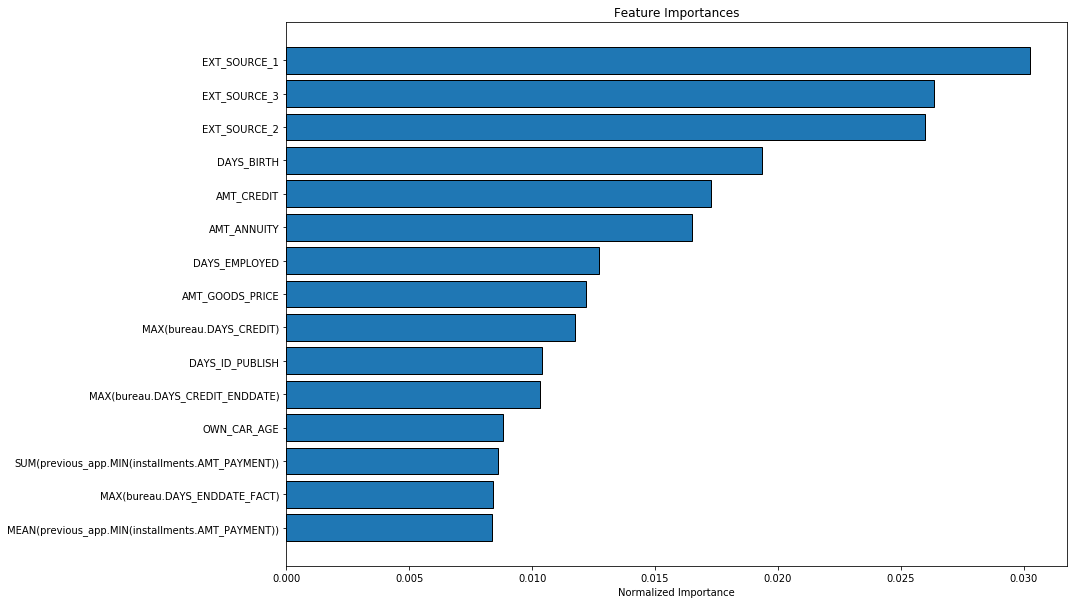

In [27]:
fi = plot_feature_importances(fi)

The most important feature created by featuretools was `MAX(bureau.DAYS_CREDIT)`. `DAYS_CREDIT` represents the number of days before the current application at Home Credit that the applicant applied for a loan at another credit institution. The maximum of this value (over the previous loans) is therefore represented by this feature. We also see several important features with a depth of two such as `MEAN(previous_app.MIN(installments.AMT_PAYMENT))` which is the average over a client's loans of the minimum value of previous credit application installment payments. 

Feature importances can be used for dimensionality reduction. They can also be used to help us better understand a problem. For example, we could use the most important features in order to concentrate on these aspects of a client when evaluating a potential loan.

In [28]:
print('There are %d features with 0 importance' % sum(fi['importance'] == 0.0))

There are 237 features with 0 importance


## Performance Experiments
I wanted to compare a number of different feature sets to determine the efficacy of manual and automated feature engineering. In order to isolate the effect of the features, the same model was used to test a number of different feature sets. The model (which can be viewed in the appendix) is a basic LightGBM algorithm using 5-fold cross validation for training and evaluation. First, we establish a control dataset, and then we carry out a series of experiments and present the results.

* Control: using only data from the `application` dataset
* Test One: manual feature engineering using only the `application`, `bureau` and `bureau_balance` data
* Test Two: manual feature engineering using all datasets
* Test Three: featuretools default features (in the `feature_matrix`)
* Test Four: featuretools specified features (in the `feature_matrix_spec`)
* Test Five: featuretools specified features combined with manual feature engineering 

The last test is still running, but the results for the other tests are shown in the data below:

| Test    | Number of Features | Validation ROC AUC | Test ROC AUC |
|---------|--------------------|--------------------|--------------|
| Control | 241                |                    |              |
| One     | 421                |                    |              |
| Two     |                    |                    |              |
| Three   | 1803               |                    |              |
| Four    | 1156               |                    |              |
| Five    |                    |                    |              |

# Conclusions

In this notebook we went through a basic implementation of using automated feature engineering with featuretools for the Home Credit Default Risk dataset. Although we did not use any advanced functionality of featuretools, we still were able to create useful features that improved the model's performance in cross validation and on the test set. Moreover, automated feature engineering took a fraction of the time spent manual feature engineering and delivered comparable results. The next steps are to use some of the advanced functionality in featuretools combined with domain knowledge to create a more useful set of features. Featuretools clearly delivers value for this problem and can results in significant efficiency gains.

### Appendix: Model (Used Across Feature Sets)
```python
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, boosting_type = 'goss',
				   objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
```